<a href="https://colab.research.google.com/github/piusopuru/Data-management-training-materials/blob/main/LakeMonitoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install xee -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.1 MB/s eta 0:00:00


In [2]:
import ee
import geemap
import xarray as xr
import xee
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
ee.Authenticate()
ee.Initialize(project="fifth-tangent-451221-f3", opt_url='https://earthengine-highvolume.googleapis.com')

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


In [4]:
# Select the area of intrest
map=geemap.Map(basemap="SATELLITE")
map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [5]:
roi = map.draw_last_feature.geometry()

start_time = '2000-01-01'
end_time = '2024-12-31'

Modis = ee.ImageCollection("MODIS/061/MOD09A1").select('sur_refl_b02', 'sur_refl_b04').filterDate(start_time, end_time).filterBounds(roi)

def add_year(img):
    date = ee.Date(img.get('system:time_start'))
    year = date.get('year')
    return img.set('year', year)

Modis_with_year = Modis.map(add_year)


years = Modis_with_year.aggregate_array('year').distinct().sort()

def yearly_mean(year):
    year = ee.Number(year)
    filtered = Modis_with_year.filter(ee.Filter.eq('year', year))
    mean_image = filtered.mean().set('year', year)
    return mean_image

yearly_means = ee.ImageCollection(years.map(yearly_mean))



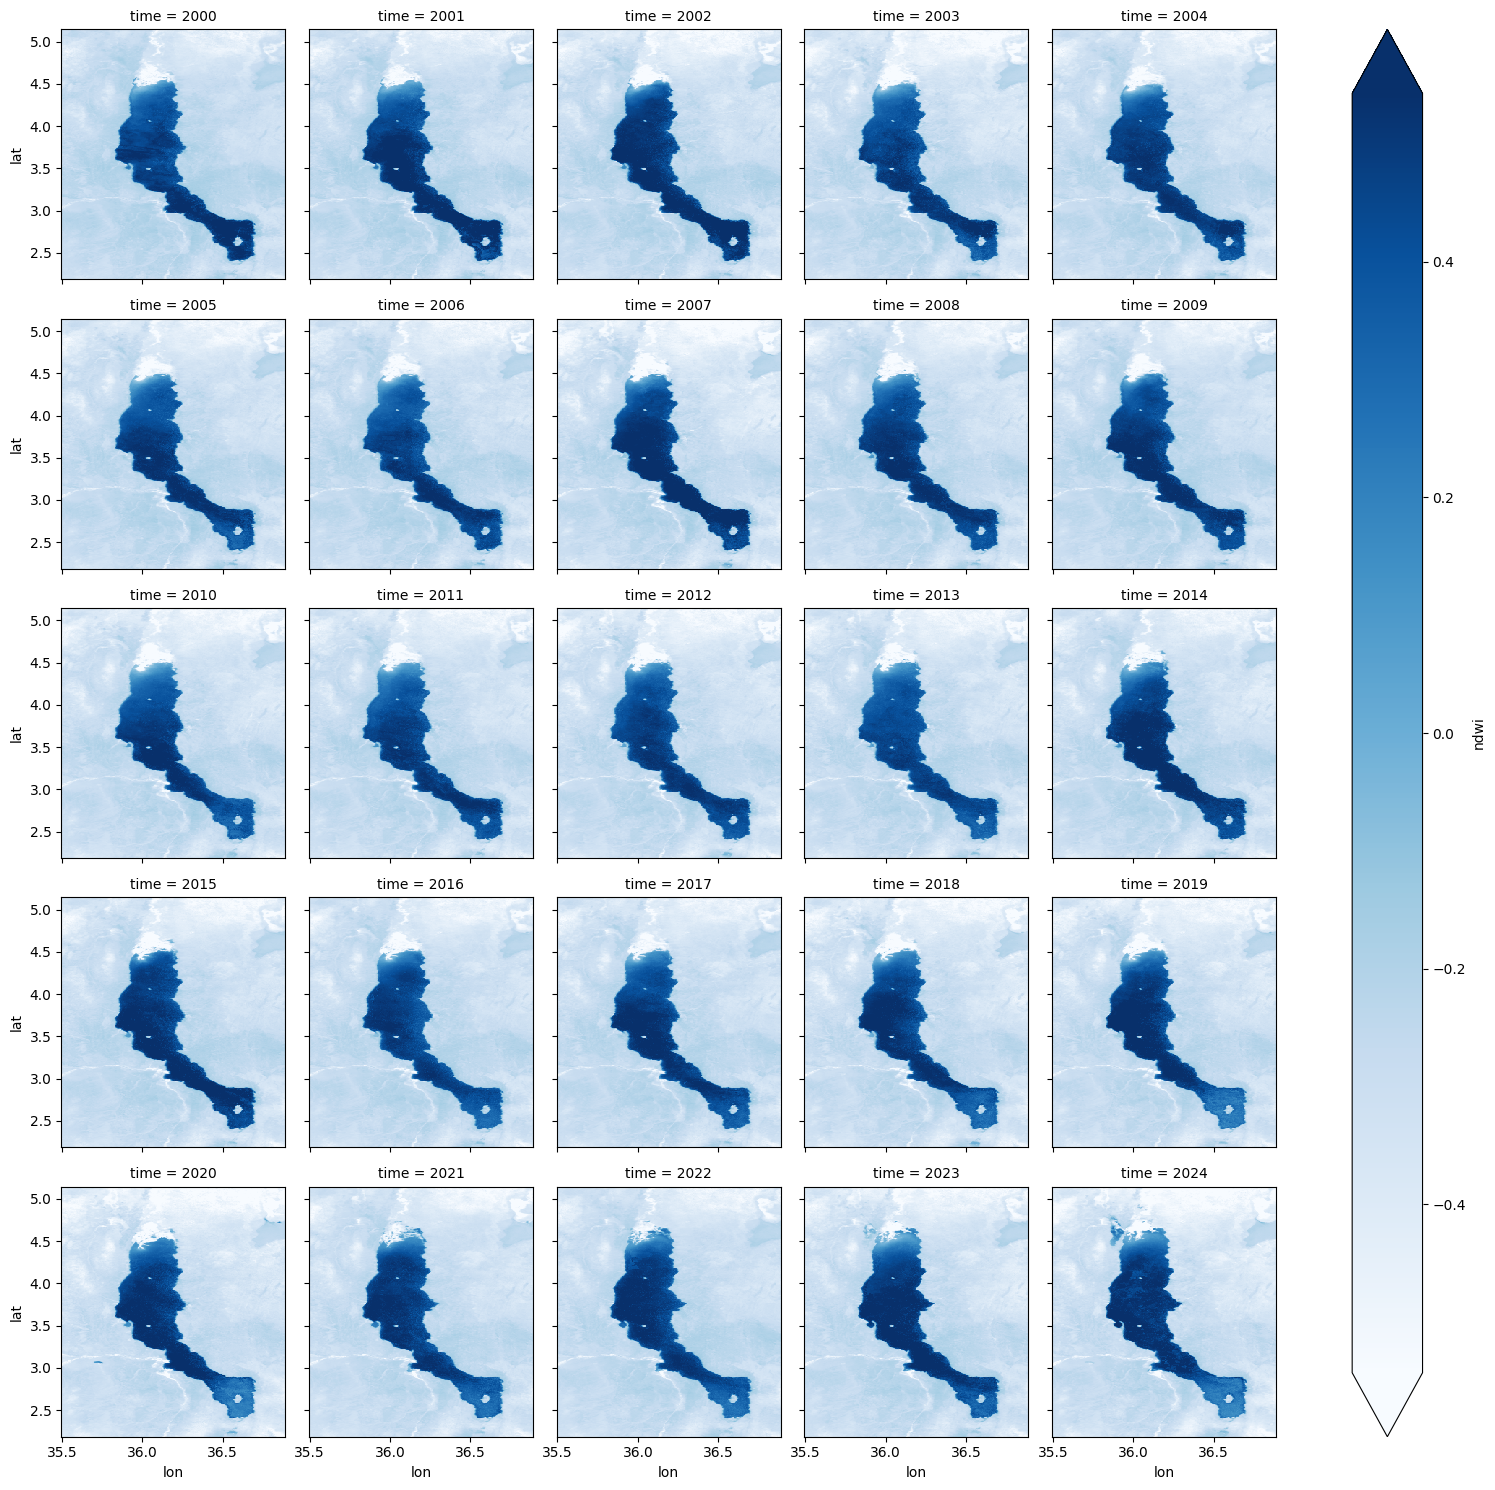

In [6]:
def ndwi(img):
    index = img.normalizedDifference(['sur_refl_b04','sur_refl_b02']).rename('ndwi')
    return index.copyProperties(img, img.propertyNames())

ndwi_yearly = yearly_means.map(ndwi)

years = ndwi_yearly.aggregate_array('year').getInfo()

ds = xr.open_dataset(ndwi_yearly, engine='ee', crs='EPSG:4326', scale=0.0045, geometry=roi)

new_time = pd.to_datetime([str(y) for y in years]).year

ds['time'] = new_time

ndwi_annual = ds['ndwi']

ndwi_annual.plot(
    x='lon',
    y='lat',
    cmap='Blues',
    col='time',
    col_wrap=5,
    robust=True
)

plt.savefig('lake_desiccation.png', dpi=360, bbox_inches='tight')


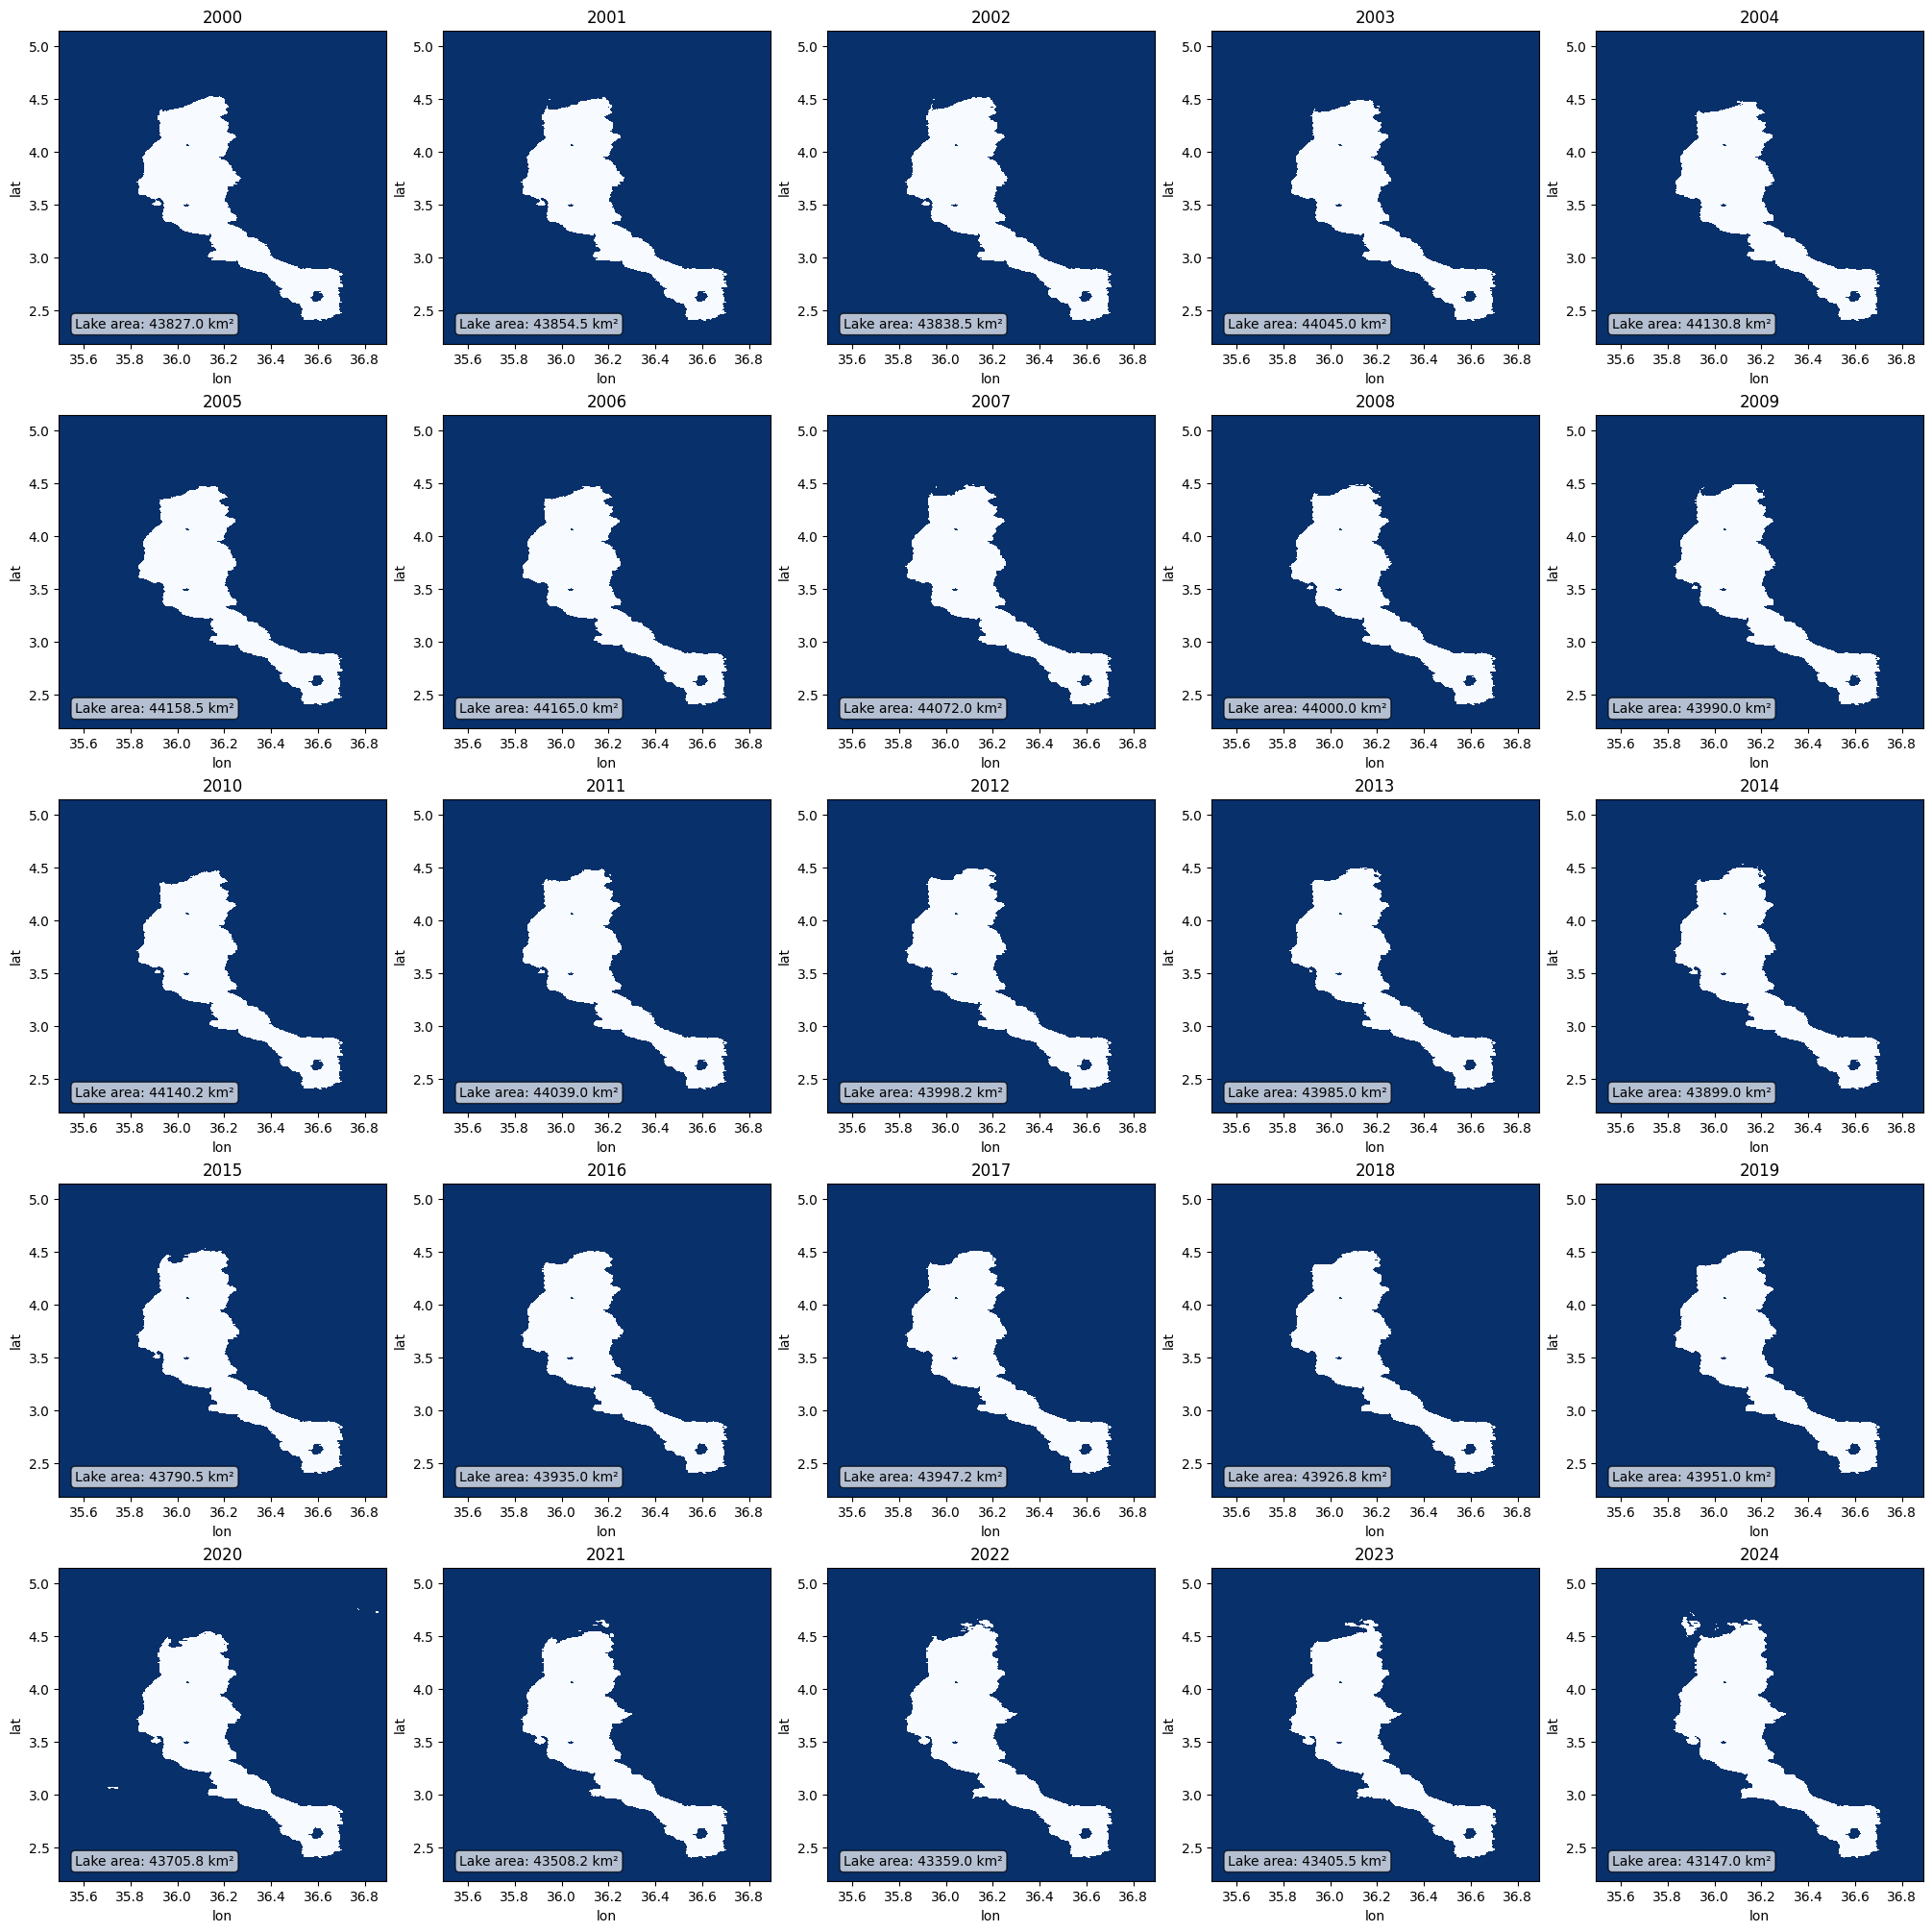

In [7]:
df = ds.to_dataframe().reset_index()

df = df.dropna(subset=['ndwi'])

model = KMeans(n_clusters=2, random_state=42)
df['clustering'] = model.fit_predict(df[['ndwi']])

xarr = df.set_index(['time', 'lat', 'lon']).to_xarray()

xarr = xarr.sortby('lon').sortby('lat')


lake_pixels_per_year = (xarr.clustering == 1).sum(dim=['lat', 'lon'])
lake_area_per_year = lake_pixels_per_year * 0.25  # km²
lake_area_values = lake_area_per_year.values

years = xarr['time'].values
n_years = len(years)
n_cols = 5
n_rows = (n_years + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows), constrained_layout=True)
axes = axes.flatten()

for i, year in enumerate(years):
    data = xarr.clustering.sel(time=year)
    im = data.plot(
        ax=axes[i],
        x='lon',
        y='lat',
        cmap='Blues',
        add_colorbar=False
    )
    year_str = pd.to_datetime(str(year)).year
    area = lake_area_values[i]
    axes[i].set_title(f"{year_str}")
    axes[i].text(
        0.05, 0.05,
        f"Lake area: {area:.1f} km²",
        transform=axes[i].transAxes,
        fontsize=10,
        bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3')
    )

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.savefig("lake_clustering_with_area_labels.png", dpi=360, bbox_inches='tight')
plt.show()
